# Adaptive Bio-CCA demo

### Imports

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time

from cca_algorithms import bio_cca, gen_oja, bio_rrr, asy_cca, adaptive_bio_cca
from util import subspace_error, correlation_matrix, add_fill_lines

### Load dataset

In [2]:
# dataset = 'synthetic'
# dataset = 'mediamill'
dataset = 'adaptive'
# dataset = 'synthetic_A'
# dataset = 'synthetic_B'
# dataset = 'synthetic_C'

In [3]:
# load dataset

X, Y, samples = {}, {}, {}

if dataset=='synthetic':
    modes = ["A"]
    X["A"] = np.load('datasets/synthetic/view1.npy')
    Y["A"] = np.load('datasets/synthetic/view2.npy')
elif dataset=='mediamill':
    modes = ["A"]
    X["A"] = np.load('datasets/mediamill/view1.npy')
    Y["A"] = np.load('datasets/mediamill/view2.npy')
elif dataset=='adaptive':
    modes = ["A", "B", "C"]
    X["A"] = np.load('datasets/adaptive/view1a.npy')
    Y["A"] = np.load('datasets/adaptive/view2a.npy')
    X["B"] = np.load('datasets/adaptive/view1b.npy')
    Y["B"] = np.load('datasets/adaptive/view2b.npy')
    X["C"] = np.load('datasets/adaptive/view1c.npy')
    Y["C"] = np.load('datasets/adaptive/view2c.npy')
elif dataset=='synthetic_A':
    modes = ["A"]
    X["A"] = np.load('datasets/adaptive/view1a.npy')
    Y["A"] = np.load('datasets/adaptive/view2a.npy')
elif dataset=='synthetic_B':
    modes = ["A"]
    X["A"] = np.load('datasets/adaptive/view1b.npy')
    Y["A"] = np.load('datasets/adaptive/view2b.npy')
elif dataset=='synthetic_C':
    modes = ["A"]
    X["A"] = np.load('datasets/adaptive/view1c.npy')
    Y["A"] = np.load('datasets/adaptive/view2c.npy')

# dataset dimensions

x_dim = X["A"].shape[0]
y_dim = Y["A"].shape[0]

for mode in modes:
    samples[mode] = X[mode].shape[1]

### Offline solution

In [4]:
Cxx, Cyy, Cxy, Rxy, u, canonical_correlations, vh = {}, {}, {}, {}, {}, {}, {}

for mode in modes:
    Cxx[mode] = X[mode]@X[mode].T/samples[mode]
    Cyy[mode] = Y[mode]@Y[mode].T/samples[mode]
    Cxy[mode] = X[mode]@Y[mode].T/samples[mode]
    Rxy[mode] = correlation_matrix(Cxx[mode],Cyy[mode],Cxy[mode])
    u[mode], canonical_correlations[mode], vh[mode] = np.linalg.svd(Rxy[mode])

### Plot canonical correlations

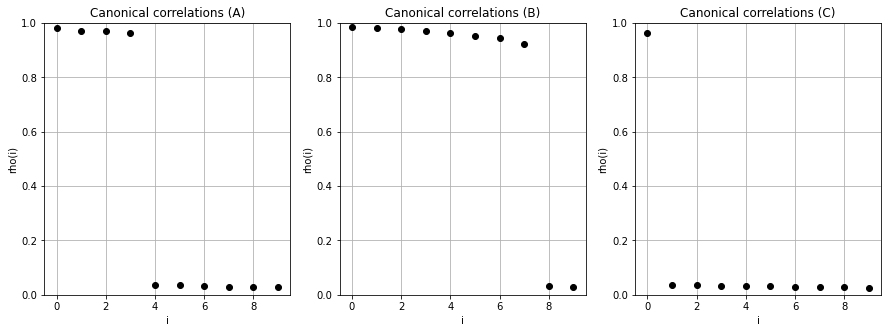

In [5]:
fig = plt.figure(figsize=(5*len(modes),5))

i = 1

for mode in modes:

    ax = plt.subplot(1, len(modes), i)

    ax.plot(canonical_correlations[mode], 'o', color='black')
    plt.xlim(-.5,9.5)
    plt.ylim(0,1)
    plt.title(f'Canonical correlations ({mode})')
    plt.xlabel('i')
    plt.ylabel('rho(i)')
    plt.grid()
    
    i += 1

plt.show()

In [6]:
z_dim = 10; alpha = 1.5

In [7]:
r = {}

for mode in modes:
    r[mode] = min(sum(1 for i in canonical_correlations[mode] if 1+i>alpha),z_dim)

In [8]:
# Optimal subspace projections

Ux, Uy, Px_opt, Py_opt = {}, {}, {}, {}

for mode in modes:
    Ux[mode] = u[mode][:,:r[mode]]
    Uy[mode] = vh[mode].T[:,:r[mode]]

    Px_opt[mode] = Ux[mode]@Ux[mode].T
    Py_opt[mode] = Uy[mode]@Uy[mode].T

### Offline algorithm

In [9]:
# Offline algorithm parameters

trials = 1; eta = 1e-2; tau = .1

iters = 1000; total_iters = 0

for mode in modes:
    total_iters += iters

In [10]:
start_time = time.time()

alg_subspacex_error = {}
alg_subspacex_error['Adaptive Bio-CCA'] = np.zeros((trials,total_iters))

for i_trial in range(trials):
    
    adaptive_Vx = np.zeros((total_iters,x_dim,z_dim))
    adaptive_Vy = np.zeros((total_iters,y_dim,z_dim))
    
    print(f'Trial {i_trial+1} out of {trials}:')
                    
    print('Running offline algorithms...')
    
    Wx = np.random.randn(z_dim,x_dim)/np.sqrt(x_dim)
    Wy = np.random.randn(z_dim,y_dim)/np.sqrt(y_dim)
    P = np.eye(z_dim)
    
    prev_iters = 0
    
    for mode in modes:
        
        print(f'Mode {mode}:')
        
        # Offline updates

        for i_iter in range(iters):
            
            PP_inv = np.linalg.inv(P@P.T+alpha*np.eye(z_dim))
            Wx += 2*eta*(PP_inv@(Wx@Cxx[mode]+Wy@Cxy[mode].T)-Wx@Cxx[mode])
            Wy += 2*eta*(PP_inv@(Wx@Cxy[mode]+Wy@Cyy[mode].T)-Wy@Cyy[mode])
            P += (eta/tau)*(PP_inv@(Wx@Cxx[mode]@Wx.T+Wx@Cxy[mode]@Wy.T+Wy@Cxy[mode].T@Wx.T+Wy@Cyy[mode]@Wy.T)@PP_inv@P-P)

            adaptive_Vx[i_iter] = Wx.T@PP_inv 
            adaptive_Vy[i_iter] = Wy.T@PP_inv

        print(f'Elapsed time: {time.time()-start_time} seconds')
                
        # Compute error

        print('Computing errors...')

        for i_iter in range(iters):
            ux, sx, vxh = np.linalg.svd(adaptive_Vx[i_iter])
            alg_subspacex_error['Adaptive Bio-CCA'][i_trial,prev_iters+i_iter] = subspace_error(ux[:,:r[mode]], Px_opt[mode])
            
        prev_iters += iters

print('Trials complete')

Trial 1 out of 1:
Running offline algorithms...
Mode A:
Elapsed time: 0.09563803672790527 seconds
Computing errors...
Mode B:
Elapsed time: 0.26137304306030273 seconds
Computing errors...
Mode C:
Elapsed time: 0.4299941062927246 seconds
Computing errors...
Trials complete


#### Plots

In [11]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

In [12]:
colors = {}

colors['Adaptive Bio-CCA'] = 'tab:blue'

In [13]:
algorithms = ['Adaptive Bio-CCA']

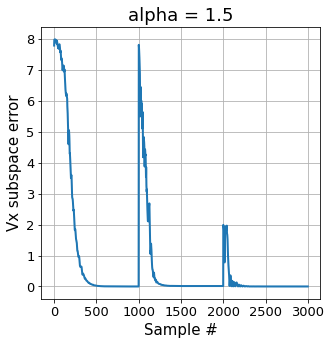

In [14]:
linewidth = 2

t = list(range(total_iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    add_fill_lines(ax, t, alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.plot()

plt.title(f"alpha = {alpha}")
plt.grid()
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

plt.show()

### Online algorithm

In [15]:
# Online algorithm parameters

trials = 5; epochs = 1; eta = 1e-4; tau = .1

total_samples = 0

for mode in modes:
    total_samples += samples[mode]*epochs

In [16]:
start_time = time.time()

alg_subspacex_error = {}
alg_subspacex_error['Adaptive Bio-CCA'] = np.zeros((trials,total_samples))

for i_trial in range(trials):
    
    adaptive_Vx = np.zeros((total_samples,x_dim,z_dim))
    adaptive_Vy = np.zeros((total_samples,y_dim,z_dim))
    
    print(f'Trial {i_trial+1} out of {trials}:')
                    
    print('Running offline algorithms...')
    
    Wx = np.random.randn(z_dim,x_dim)/np.sqrt(x_dim)
    Wy = np.random.randn(z_dim,y_dim)/np.sqrt(y_dim)
    P = np.eye(z_dim)
    
    prev_iters = 0
    
    for mode in modes:
        
        print(f'Mode {mode}:')
        
        for i_epoch in range(epochs):
            
            print(f'Epoch {i_epoch+1} out of {epochs}:')
        
            # Online updates

            idx = np.random.permutation(samples[mode])

            # Online updates

            for i_sample in range(samples[mode]):

                i_iter = prev_iters + i_sample

                x = X[mode][:,idx[i_sample]]
                y = Y[mode][:,idx[i_sample]]

                a = Wx@x
                b = Wy@y

                # neural dynamics

                PP_inv = np.linalg.inv(P@P.T+alpha*np.eye(z_dim))

                z = PP_inv@(a+b)
                n = P.T@z

                # synaptic updates

                Wx += 2*eta*np.outer(z-a,x)
                Wy += 2*eta*np.outer(z-b,y)
                P += (eta/tau)*(np.outer(z,n)-P)

                adaptive_Vx[i_iter] = Wx.T@PP_inv 
                adaptive_Vy[i_iter] = Wy.T@PP_inv

                ux, sx, vxh = np.linalg.svd(adaptive_Vx[i_iter])
                alg_subspacex_error['Adaptive Bio-CCA'][i_trial,i_iter] = subspace_error(ux[:,:r[mode]], Px_opt[mode])

            print(f'Elapsed time: {time.time()-start_time} seconds')
                
        prev_iters+=samples[mode]*epochs

print('Trials complete')

Trial 1 out of 5:
Running offline algorithms...
Mode A:
Epoch 1 out of 1:
Elapsed time: 15.713505029678345 seconds
Mode B:
Epoch 1 out of 1:
Elapsed time: 32.04683065414429 seconds
Mode C:
Epoch 1 out of 1:
Elapsed time: 48.013569593429565 seconds
Trial 2 out of 5:
Running offline algorithms...
Mode A:
Epoch 1 out of 1:
Elapsed time: 64.2045407295227 seconds
Mode B:
Epoch 1 out of 1:
Elapsed time: 80.20696187019348 seconds
Mode C:
Epoch 1 out of 1:
Elapsed time: 96.46695876121521 seconds
Trial 3 out of 5:
Running offline algorithms...
Mode A:
Epoch 1 out of 1:
Elapsed time: 112.4623806476593 seconds
Mode B:
Epoch 1 out of 1:
Elapsed time: 129.79061770439148 seconds
Mode C:
Epoch 1 out of 1:
Elapsed time: 146.16799688339233 seconds
Trial 4 out of 5:
Running offline algorithms...
Mode A:
Epoch 1 out of 1:
Elapsed time: 162.40976786613464 seconds
Mode B:
Epoch 1 out of 1:
Elapsed time: 179.55296993255615 seconds
Mode C:
Epoch 1 out of 1:
Elapsed time: 196.06049585342407 seconds
Trial 5 ou

#### Plots

In [17]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

In [18]:
colors = {}

colors['Adaptive Bio-CCA'] = 'tab:blue'

In [19]:
algorithms = ['Adaptive Bio-CCA']

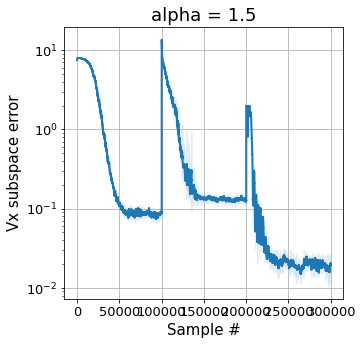

In [20]:
linewidth = 2

t = list(range(total_samples))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    add_fill_lines(ax, t, alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.semilogy()

plt.title(f"alpha = {alpha}")
plt.grid()
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

plt.show()